In [1]:
import nibabel as nib
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
!tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

2022-04-07 14:23:23.481295: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


/bin/bash: -c: line 0: syntax error near unexpected token `tf.compat.v1.logging.ERROR'
/bin/bash: -c: line 0: `tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)'


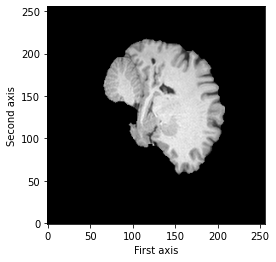

In [2]:
path = '/scratch1/nsuresh/BET_BSE_DATA/'
data = pd.read_csv(path + "Label_file.csv")

img = nib.load(filename = path + 'files/' + data['Filename'][918 + 248])
#img = nib.load(filename = filepath) # specify filepath to be loaded
img_data = img.get_fdata()
test = img_data[:,:,59]

plt.imshow(test, cmap='gray', origin='lower')
plt.xlabel('First axis')
plt.ylabel('Second axis')
plt.show()

In [3]:
## Preprocessing your datafile
from scipy import ndimage

def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath).get_fdata()
    return scan

def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    return volume.astype("float32")

def resize_volume(img):
    depth_factor = 1 / (img.shape[-1] / 64)
    width_factor = 1 / (img.shape[0] / 128)
    height_factor = 1 / (img.shape[1] / 128)
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [4]:
np_data = np.array(process_scan(path + 'files/' + data['Filename'][918 + 248]))
#np_data = np.array(process_scan(filepath))

In [6]:
model = keras.models.load_model('3d_image_classification.h5')
model.load_weights("3d_image_classification.h5")
prediction = model.predict(np.expand_dims(np_data, axis=0))
scores = [1 - prediction[0], prediction[0]]

class_names = ["does not have", "has"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that the MRI %s recognizable facial features."
        % ((100 * score), name)
    )

This model is 96.55 percent confident that the MRI does not have recognizable facial features.
This model is 3.45 percent confident that the MRI has recognizable facial features.
